In [222]:
%matplotlib inline

In [223]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [248]:
import sys
sys.path.append('.')

import pandas as pd
import numpy as np
import incense
from incense import ExperimentLoader
import matplotlib.pyplot as plt
from src import settings

# Print helpers
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import Terminal256Formatter
from pprint import pformat

def save_table(str_, label):
    print(str_)
    with open('thesis_tables/{}.tex'.format(label),'w') as tf:
        tf.write(str_)

def pprint_color(obj):
    print(highlight(pformat(obj), PythonLexer(), Terminal256Formatter()))

# Load    
loader = ExperimentLoader(
    mongo_uri=settings.MONGO_DB_URL,
    db_name=settings.MONGO_DB_NAME
)

In [225]:
import addict

def get_name(exp_row):
    # Create short hand name for convinience
    name = exp_row['model']
    if exp_row['bo']: 
        name = name + " BO"
    if exp_row['acq'] is not None: 
        name = name + " " + exp_row['acq']
    name = name + " " + exp_row['f']
    return name

def prefix_dict(dict_, prefix):
    return {"{}{}".format(prefix, k): v for k,v in dict_.items()}

def get_exp_key_col(exp):
    config = exp.to_dict()['config']

    if config.model.name != 'TransformerModel':
        name = config.model.name
    else:
        kwargs = config.model.kwargs
        name = "T<{},{}>".format(kwargs['transformer']['name'], kwargs['prob_model']['name'])
    
    exp_row = {
        settings.MODEL_HASH: config[settings.MODEL_HASH],
        settings.EXP_HASH: config[settings.EXP_HASH],
        'model': name,
        'model2': config.get('model2', {}).get('name', None),
        'acq': config.get('acquisition_function', {}).get('name'),
        'bo': bool(config.get('bo', None)),
        'f': config['obj_func']['name'],
        'config': addict.Dict(config),
        'tag': config['tag'],
        'exp': exp,
        'id': exp.id,
    }
    # Create short hand name for convinience
    exp_row['name'] = get_name(exp_row)
    
    # Unpack the results as columns
    exp_row.update(prefix_dict(exp.result, 'result.'))
    
    return exp_row

def get_bo_plots(exp):
    return {k: v for k,v in exp.artifacts.items() if k.startswith('bo-plot')}

# Show aggregate


In [226]:
def create_SG_df(df, depth=3, refinement_level=10, f_tol=1e-3):
    """Runs SG and A-SG for every unique function in `df`.
    """
    # Performance of SG and A-SG
    functions = df.drop_duplicates(subset='f')['config'].apply(lambda c: c.obj_func)
    functions

    # Add SG and A-SG to all f
    from src import environments as environments_module
    from runner import unpack
    from src.models.asg import AdaptiveSparseGrid

    # Remove multiindex for easy appending
    SG_df = pd.DataFrame()

    for func in functions:
        name, args, kwargs = unpack(func)
        f = getattr(environments_module, name)(**kwargs)

        print("Fitting SG")
        sg = AdaptiveSparseGrid(f, depth=depth, refinement_level=0)
        sg.fit()

        print("Fitting A-SG")
        asg = AdaptiveSparseGrid(f, depth=1, refinement_level=refinement_level, f_tol=f_tol, point_tol=1000)
        asg.fit()

        sg_rmse, sg_max_err = _calc_errors(sg.evaluate, f, f, rand=True)
        asg_rmse, asg_max_err = _calc_errors(asg.evaluate, f, f, rand=True)

        SG_df = SG_df.append([{'model': 'SG', 'f': func.name, 'result.rmse': sg_rmse, 
                               'N': sg.grid.getNumPoints(), 'depth': sg.total_depth}])
        SG_df = SG_df.append([{'model': 'A-SG', 'f': func.name, 'result.rmse': asg_rmse, 
                               'N': asg.grid.getNumPoints(), 'depth': asg.total_depth}])

    SG_df = SG_df.set_index(['model', 'f']).sort_index()
    return SG_df

In [128]:
exps = loader.find({'status': 'COMPLETED'})
df = pd.DataFrame([get_exp_key_col(exp) for exp in exps])
df = df.set_index(['exp_hash', 'id'])
df

,,acq,bo,config,exp,f,model,model2,model_hash,name,result.max_err,result.model1:max_err,result.model1:rmse,result.model_compare:mean:max_err,result.model_compare:mean:rmse,result.model_compare:var:max_err,result.model_compare:var:rmse,result.rmse,tag
exp_hash,id,,,,,,,,,,,,,,,,,,
5e30ad2c8a0798f03c4e09bc371bb635f63433b2,1,None,False,{'exp_hash': '5e30ad2c8a0798f03c4e09bc371bb635...,"Experiment(id=1, name=lions)",Sinc,DKLGPModel,GPModel,77cc4c25e244d4133ae9b866f752537989f59b9a,DKLGPModel Sinc,0.006653,0.005119,0.001376,0.001552,0.000186,0.010009,0.010000,0.001480,certify-ExactDKL
27807c8cd2c7cdd9f9e83b20194873ab0bf1bb90,2,None,False,{'exp_hash': '27807c8cd2c7cdd9f9e83b20194873ab...,"Experiment(id=2, name=lions)",Sinc,DKLGPModel,GPModel,3697a59e6ce15ea5ae6f0827998322d0314c6483,DKLGPModel Sinc,0.005409,0.004813,0.001347,0.005614,0.002155,0.011207,0.009306,0.001847,certify-ExactDKL
a5eaf714eadb767a3950580007c9c83fad3993ae,3,None,False,{'exp_hash': 'a5eaf714eadb767a3950580007c9c83f...,"Experiment(id=3, name=lions)",Sinc,DKLGPModel,GPModel,1227d6f51d75931527cf3dda329541c26422d34c,DKLGPModel Sinc,0.005573,0.004472,0.001442,0.000902,0.000143,0.010009,0.009993,0.001446,certify-ExactDKL
1ea3be78e884ee844376f36b2f8b4caccce6b195,4,None,False,{'exp_hash': '1ea3be78e884ee844376f36b2f8b4cac...,"Experiment(id=4, name=lions)",Sinc,DKLGPModel,GPModel,47fb288ccc4f277d600e0c13f5412ab72ad404d5,DKLGPModel Sinc,0.007773,0.005994,0.001466,0.001774,0.000181,0.010002,0.010000,0.001559,certify-ExactDKL
20716d05eed5faddbc813dbf229314e0e6955c90,5,None,False,{'exp_hash': '20716d05eed5faddbc813dbf229314e0...,"Experiment(id=5, name=lions)",Sinc,DKLGPModel,GPModel,60b101aa058e7c235afdd39507e56ee68cfa125e,DKLGPModel Sinc,0.007222,0.005990,0.001382,0.001678,0.000203,0.010024,0.009998,0.001526,certify-ExactDKL
b8fea5654b1e6b3fcc6ee3f2038aedef445dfa99,6,None,False,{'exp_hash': 'b8fea5654b1e6b3fcc6ee3f2038aedef...,"Experiment(id=6, name=lions)",Branin,DKLGPModel,GPModel,77cc4c25e244d4133ae9b866f752537989f59b9a,DKLGPModel Branin,7.725012,0.155126,0.013645,26.298115,1.084565,0.830189,0.056863,0.699476,certify-ExactDKL
31d09111f4e6c010c994e84afd41506b4f43f283,7,None,False,{'exp_hash': '31d09111f4e6c010c994e84afd41506b...,"Experiment(id=7, name=lions)",Branin,DKLGPModel,GPModel,60b101aa058e7c235afdd39507e56ee68cfa125e,DKLGPModel Branin,11.680366,0.119955,0.011999,26.302370,1.329572,0.371106,0.022434,0.861570,certify-ExactDKL
058d6232c6cf4d19a2e62d9e39c327366762900c,8,None,False,{'exp_hash': '058d6232c6cf4d19a2e62d9e39c32736...,"Experiment(id=8, name=lions)",Branin,DKLGPModel,GPModel,02c9e70e08af2d283a42dfe83204171e4ab99e57,DKLGPModel Branin,12.974419,0.133092,0.012611,15.863464,1.636808,0.238598,0.018486,1.036292,certify-ExactDKL
3e8403dc411b7f7388c3931a136d124cfe8edd7d,9,None,False,{'exp_hash': '3e8403dc411b7f7388c3931a136d124c...,"Experiment(id=9, name=lions)",Branin,DKLGPModel,GPModel,3697a59e6ce15ea5ae6f0827998322d0314c6483,DKLGPModel Branin,24.712460,0.129181,0.013842,41.845051,2.213217,0.131863,0.010239,1.347367,certify-ExactDKL


## Plot BO CI

In [209]:
#exps_row = df.loc[df.bo == True].iloc[0]
exps_row = df.loc["60519fa6dbfe5a80969a4b30ddd14cafbf68612f"] # Kink1D
# exps_row = df.loc["75d24ad445d397dbe1a8add031764c707d37cfdf"] # IncreasingOscillationDecreasingAmplitude
exps = exps_row.exps

def get_rmse(exp):
    """Uses old `mse` as fallback."""
    return exp.metrics.get('rmse', exp.metrics.get('mse',pd.Series([])))

def plot_bo_regret(exps, label=None):
    df_concat = pd.concat([get_rmse(exp) for exp in exps], axis=1)
    mean = df_concat.mean(axis=1)
    var = df_concat.var(axis=1)
    plt.plot(df_concat.index, mean, label=label)
    plt.fill_between(df_concat.index, mean - 2 * np.sqrt(var), mean + 2 * np.sqrt(var), alpha=0.2)

KeyError: '60519fa6dbfe5a80969a4b30ddd14cafbf68612f'

In [20]:
# Calculate mean and variance of MSE
# TODO: maybe not silence missing MSE...
plot_bo_regret(exps, label="Regret")
plt.legend()

NameError: name 'plot_bo_regret' is not defined

In [21]:
# Plot all last BO plot
# TODO: plot in grid
for i, exp in enumerate(exps):
    name, last_plot = sorted(get_bo_plots(exp).items())[-1]
    last_plot.show()
    plt.title("Experiment {}:".format(i))

IndexError: list index out of range

## Plot GP final MSE

### Certify ExactDKL

In [249]:
exps_rows_df = df[df["tag"] == "certify-ExactDKL"].copy()

# DKLGPModel
# Pick layers (and convert to tuples for hashability which is required for indexing).
exps_rows_df['layers'] = exps_rows_df.apply(lambda row: row.config.model.kwargs.nn_kwargs.get('layers'), axis=1)
exps_rows_df['layers'] = exps_rows_df.apply(lambda row: tuple(row.layers) if row.layers is not None else (), axis=1)

exps_rows_df['n_iter'] = exps_rows_df.apply(lambda row: row.config.model.kwargs.get('n_iter'), axis=1)
exps_rows_df['learning_rate'] = exps_rows_df.apply(lambda row: row.config.model.kwargs.get('learning_rate'), axis=1)

# GPModel
exps_rows_df['kernel'] = exps_rows_df.apply(lambda row: row.config.model.kwargs.kernel.get('name'), axis=1)
exps_rows_df

,,acq,bo,config,exp,f,model,model2,model_hash,name,result.max_err,...,result.model_compare:mean:max_err,result.model_compare:mean:rmse,result.model_compare:var:max_err,result.model_compare:var:rmse,result.rmse,tag,layers,n_iter,learning_rate,kernel
exp_hash,id,,,,,,,,,,,,,,,,,,,,,
5e30ad2c8a0798f03c4e09bc371bb635f63433b2,1,None,False,{'exp_hash': '5e30ad2c8a0798f03c4e09bc371bb635...,"Experiment(id=1, name=lions)",Sinc,DKLGPModel,GPModel,77cc4c25e244d4133ae9b866f752537989f59b9a,DKLGPModel Sinc,0.006653,...,0.001552,0.000186,0.010009,0.010000,0.001480,certify-ExactDKL,(),1000,0.10,None
27807c8cd2c7cdd9f9e83b20194873ab0bf1bb90,2,None,False,{'exp_hash': '27807c8cd2c7cdd9f9e83b20194873ab...,"Experiment(id=2, name=lions)",Sinc,DKLGPModel,GPModel,3697a59e6ce15ea5ae6f0827998322d0314c6483,DKLGPModel Sinc,0.005409,...,0.005614,0.002155,0.011207,0.009306,0.001847,certify-ExactDKL,(),100,0.01,None
a5eaf714eadb767a3950580007c9c83fad3993ae,3,None,False,{'exp_hash': 'a5eaf714eadb767a3950580007c9c83f...,"Experiment(id=3, name=lions)",Sinc,DKLGPModel,GPModel,1227d6f51d75931527cf3dda329541c26422d34c,DKLGPModel Sinc,0.005573,...,0.000902,0.000143,0.010009,0.009993,0.001446,certify-ExactDKL,(),1000,0.01,None
1ea3be78e884ee844376f36b2f8b4caccce6b195,4,None,False,{'exp_hash': '1ea3be78e884ee844376f36b2f8b4cac...,"Experiment(id=4, name=lions)",Sinc,DKLGPModel,GPModel,47fb288ccc4f277d600e0c13f5412ab72ad404d5,DKLGPModel Sinc,0.007773,...,0.001774,0.000181,0.010002,0.010000,0.001559,certify-ExactDKL,(),1000,0.05,None
20716d05eed5faddbc813dbf229314e0e6955c90,5,None,False,{'exp_hash': '20716d05eed5faddbc813dbf229314e0...,"Experiment(id=5, name=lions)",Sinc,DKLGPModel,GPModel,60b101aa058e7c235afdd39507e56ee68cfa125e,DKLGPModel Sinc,0.007222,...,0.001678,0.000203,0.010024,0.009998,0.001526,certify-ExactDKL,(),100,0.10,None
b8fea5654b1e6b3fcc6ee3f2038aedef445dfa99,6,None,False,{'exp_hash': 'b8fea5654b1e6b3fcc6ee3f2038aedef...,"Experiment(id=6, name=lions)",Branin,DKLGPModel,GPModel,77cc4c25e244d4133ae9b866f752537989f59b9a,DKLGPModel Branin,7.725012,...,26.298115,1.084565,0.830189,0.056863,0.699476,certify-ExactDKL,(),1000,0.10,None
31d09111f4e6c010c994e84afd41506b4f43f283,7,None,False,{'exp_hash': '31d09111f4e6c010c994e84afd41506b...,"Experiment(id=7, name=lions)",Branin,DKLGPModel,GPModel,60b101aa058e7c235afdd39507e56ee68cfa125e,DKLGPModel Branin,11.680366,...,26.302370,1.329572,0.371106,0.022434,0.861570,certify-ExactDKL,(),100,0.10,None
058d6232c6cf4d19a2e62d9e39c327366762900c,8,None,False,{'exp_hash': '058d6232c6cf4d19a2e62d9e39c32736...,"Experiment(id=8, name=lions)",Branin,DKLGPModel,GPModel,02c9e70e08af2d283a42dfe83204171e4ab99e57,DKLGPModel Branin,12.974419,...,15.863464,1.636808,0.238598,0.018486,1.036292,certify-ExactDKL,(),100,0.05,None
3e8403dc411b7f7388c3931a136d124cfe8edd7d,9,None,False,{'exp_hash': '3e8403dc411b7f7388c3931a136d124c...,"Experiment(id=9, name=lions)",Branin,DKLGPModel,GPModel,3697a59e6ce15ea5ae6f0827998322d0314c6483,DKLGPModel Branin,24.712460,...,41.845051,2.213217,0.131863,0.010239,1.347367,certify-ExactDKL,(),100,0.01,None


In [250]:
# For this specific `tag` these indexes are uniquely determinds the model.
exps_rows_df = exps_rows_df.reset_index().set_index(['model', 'n_iter', 'learning_rate', 'f'])
exps_rows_df = exps_rows_df.sort_index()
exps_rows_df

exp_hash  \
model      n_iter learning_rate f                                                     
DKLGPModel 100    0.01          Branin     3e8403dc411b7f7388c3931a136d124cfe8edd7d   
                                Sinc       27807c8cd2c7cdd9f9e83b20194873ab0bf1bb90   
                                TwoKink1D  49a6326b0f86d75e99c2fa4af740794f823ab219   
                  0.05          Branin     058d6232c6cf4d19a2e62d9e39c327366762900c   
                                Sinc       5a820f3269dc0b4fa64506ce35ef8a7bbbe620e7   
                                TwoKink1D  3861ff94600f7fc866de285c0281d299981b5171   
                  0.10          Branin     31d09111f4e6c010c994e84afd41506b4f43f283   
                                Sinc       20716d05eed5faddbc813dbf229314e0e6955c90   
                                TwoKink1D  6a5aa5b0c4c5c25c418f4ac7fc0be44e8e92708d   
           1000   0.01          Branin     d361a65659bf3e6636fce3ed32e9a757fa82fa8d   
                                Sinc       a5eaf714eadb767a3950580007c9c83fad3993ae   
                                TwoKink1D  396328e0912808bb8229cd088f0c6a59d171fec0   
                  0.05          Branin     468ddb1ed3c0c2e125cc7baf57f22ede775bbea7   
                                Sinc       1ea3be78e884ee844376f36b2f8b4caccce6b195   
                                TwoKink1D  066206db16d7cce9384293c4485e9eb08aa1a93c   
                  0.10          Branin     b8fea5654b1e6b3fcc6ee3f2038aedef445dfa99   
                                Sinc       5e30ad2c8a0798f03c4e09bc371bb635f63433b2   
                                TwoKink1D  0a56cbb9d803561f1a67947d5a9c0596a43aae9e   

                                           id   acq     bo  \
model      n_iter learning_rate f                            
DKLGPModel 100    0.01          Branin      9  None  False   
                                Sinc        2  None  False   
                                TwoKink1D  16  None  False   
                  0.05          Branin      8  None  False   
                                Sinc       36  None  False   
                                TwoKink1D  12  None  False   
                  0.10          Branin      7  None  False   
                                Sinc        5  None  False   
                                TwoKink1D  15  None  False   
           1000   0.01          Branin     10  None  False   
                                Sinc        3  None  False   
                                TwoKink1D  14  None  False   
                  0.05          Branin     11  None  False   
                                Sinc        4  None  False   
                                TwoKink1D  13  None  False   
                  0.10          Branin      6  None  False   
                                Sinc        1  None  False   
                                TwoKink1D  17  None  False   

                                                                                      config  \
model      n_iter learning_rate f                                                              
DKLGPModel 100    0.01          Branin     {'exp_hash': '3e8403dc411b7f7388c3931a136d124c...   
                                Sinc       {'exp_hash': '27807c8cd2c7cdd9f9e83b20194873ab...   
                                TwoKink1D  {'exp_hash': '49a6326b0f86d75e99c2fa4af740794f...   
                  0.05          Branin     {'exp_hash': '058d6232c6cf4d19a2e62d9e39c32736...   
                                Sinc       {'exp_hash': '5a820f3269dc0b4fa64506ce35ef8a7b...   
                                TwoKink1D  {'exp_hash': '3861ff94600f7fc866de285c0281d299...   
                  0.10          Branin     {'exp_hash': '31d09111f4e6c010c994e84afd41506b...   
                                Sinc       {'exp_hash': '20716d05eed5faddbc813dbf229314e0...   
                                TwoKink1D  {'exp_hash': '6a5aa5b0c4c5c25c418f4ac7fc0be44e...   
           1000   0.01          Brani

In [251]:
# Possible metrics to aggregate and display
RESULT_COLS = list(filter(lambda x: x.startswith("result."), exps_rows_df.columns))
RESULT_COLS

['result.max_err',
 'result.model1:max_err',
 'result.model1:rmse',
 'result.model_compare:mean:max_err',
 'result.model_compare:mean:rmse',
 'result.model_compare:var:max_err',
 'result.model_compare:var:rmse',
 'result.rmse']

In [252]:
# Show aggregate for specific metrics across all functions
# This view makes for easy access to exp_hash.
RESULT = "result.model_compare:mean:rmse"
RESULTS = [
# 'result.rmse',
# 'result.max_err',
# 'result.model1:max_err',
# 'result.model1:rmse',
 'result.model_compare:mean:max_err',
 'result.model_compare:mean:rmse',
 'result.model_compare:var:max_err',
 'result.model_compare:var:rmse',
]

# Aggregate some result
def agg(col):
    if col.name.startswith('result.'):
        return np.nanmean(col)
    return col.iloc[0]

exps_rows_df = exps_rows_df.reset_index().groupby('exp_hash').agg(agg)

# If this throws warning it is because the indexes does not uniquely determind the model
multi_df = exps_rows_df.reset_index().set_index(['model', 'n_iter', 'learning_rate', 'f'])
multi_df = multi_df.sort_index()
multi_df[RESULTS + ['exp_hash']]

result.model_compare:mean:max_err  \
model      n_iter learning_rate f                                              
DKLGPModel 100    0.01          Branin                             41.845051   
                                Sinc                                0.005614   
                                TwoKink1D                           0.011581   
                  0.05          Branin                             15.863464   
                                Sinc                                0.000814   
                                TwoKink1D                           0.007351   
                  0.10          Branin                             26.302370   
                                Sinc                                0.001678   
                                TwoKink1D                           0.004032   
           1000   0.01          Branin                             33.200770   
                                Sinc                                0.000902   
                                TwoKink1D                           0.004317   
                  0.05          Branin                             27.654249   
                                Sinc                                0.001774   
                                TwoKink1D                           0.004245   
                  0.10          Branin                             26.298115   
                                Sinc                                0.001552   
                                TwoKink1D                           0.004302   

                                           result.model_compare:mean:rmse  \
model      n_iter learning_rate f                                           
DKLGPModel 100    0.01          Branin                           2.213217   
                                Sinc                             0.002155   
                                TwoKink1D                        0.004742   
                  0.05          Branin                           1.636808   
                                Sinc                             0.000338   
                                TwoKink1D                        0.001557   
                  0.10          Branin                           1.329572   
                                Sinc                             0.000203   
                                TwoKink1D                        0.000569   
           1000   0.01          Branin                           1.437028   
                                Sinc                             0.000143   
                                TwoKink1D                        0.000562   
                  0.05          Branin                           1.517571   
                                Sinc                             0.000181   
                                TwoKink1D                        0.000581   
                  0.10          Branin                           1.084565   
                                Sinc                             0.000186   
                                TwoKink1D                        0.000629   

                                           result.model_compare:var:max_err  \
model      n_iter learning_rate f                                             
DKLGPModel 100    0.01          Branin                             0.131863   
                                Sinc                               0.011207   
                                TwoKink1D                          0.010258   
                  0.05          Branin                             0.238598   
                                Sinc                               0.010041   
                                TwoKink1D                          0.010013   
                  0.10          Branin                             0.371106   
                                Sinc                               0.010024   
                                TwoKink1D                          0.010043   
           1000   0.01          

In [253]:
# View that put function in multiindexed column
multi_df[RESULTS].reset_index().groupby(['model', 'n_iter', 'learning_rate']).agg('mean')

result.model_compare:mean:max_err  \
model      n_iter learning_rate                                      
DKLGPModel 100    0.01                                   13.954082   
                  0.05                                    5.290543   
                  0.10                                    8.769360   
           1000   0.01                                   11.068663   
                  0.05                                    9.220089   
                  0.10                                    8.767990   

                                 result.model_compare:mean:rmse  \
model      n_iter learning_rate                                   
DKLGPModel 100    0.01                                 0.740038   
                  0.05                                 0.546234   
                  0.10                                 0.443448   
           1000   0.01                                 0.479244   
                  0.05                                 0.506111   
                  0.10                                 0.361793   

                                 result.model_compare:var:max_err  \
model      n_iter learning_rate                                     
DKLGPModel 100    0.01                                   0.051109   
                  0.05                                   0.086217   
                  0.10                                   0.130391   
           1000   0.01                                   0.076848   
                  0.05                                   0.399433   
                  0.10                                   0.283409   

                                 result.model_compare:var:rmse  
model      n_iter learning_rate                                 
DKLGPModel 100    0.01                                0.009856  
                  0.05                                0.012824  
                  0.10                                0.014144  
           1000   0.01                                0.012274  
                  0.05                                0.021005  
                  0.10                                0.025621

In [254]:
# View that put function in multiindexed column
multi_df[RESULTS].sort_index().unstack('f')

result.model_compare:mean:max_err            \
f                                                          Branin      Sinc   
model      n_iter learning_rate                                               
DKLGPModel 100    0.01                                  41.845051  0.005614   
                  0.05                                  15.863464  0.000814   
                  0.10                                  26.302370  0.001678   
           1000   0.01                                  33.200770  0.000902   
                  0.05                                  27.654249  0.001774   
                  0.10                                  26.298115  0.001552   

                                          result.model_compare:mean:rmse  \
f                               TwoKink1D                         Branin   
model      n_iter learning_rate                                            
DKLGPModel 100    0.01           0.011581                       2.213217   
                  0.05           0.007351                       1.636808   
                  0.10           0.004032                       1.329572   
           1000   0.01           0.004317                       1.437028   
                  0.05           0.004245                       1.517571   
                  0.10           0.004302                       1.084565   

                                                     \
f                                    Sinc TwoKink1D   
model      n_iter learning_rate                       
DKLGPModel 100    0.01           0.002155  0.004742   
                  0.05           0.000338  0.001557   
                  0.10           0.000203  0.000569   
           1000   0.01           0.000143  0.000562   
                  0.05           0.000181  0.000581   
                  0.10           0.000186  0.000629   

                                result.model_compare:var:max_err            \
f                                                         Branin      Sinc   
model      n_iter learning_rate                                              
DKLGPModel 100    0.01                                  0.131863  0.011207   
                  0.05                                  0.238598  0.010041   
                  0.10                                  0.371106  0.010024   
           1000   0.01                                  0.210501  0.010009   
                  0.05                                  1.178263  0.010002   
                  0.10                                  0.830189  0.010009   

                                          result.model_compare:var:rmse  \
f                               TwoKink1D                        Branin   
model      n_iter learning_rate                                           
DKLGPModel 100    0.01           0.010258                      0.010239   
                  0.05           0.010013                      0.018486   
                  0.10           0.010043                      0.022434   
           1000   0.01           0.010033                      0.016829   
                  0.05           0.010036                      0.043013   
                  0.10           0.010030                      0.056863   

                                                     
f                                    Sinc TwoKink1D  
model      n_iter learning_rate                      
DKLGPModel 100    0.01           0.009306  0.010022  
                  0.05           0.009984  0.010002  
                  0.10           0.009998  0.010000  
           1000   0.01           0.009993  0.010001  
                  0.05           0.010000  0.010001  
                  0.10           0.010000  0.010000

In [255]:
# \label{table:dkl-identity}
temp_df = multi_df.reset_index().set_index(['n_iter', 'learning_rate', 'f'])[RESULTS].sort_index().unstack('f')
temp_df = temp_df.copy()
temp_df = temp_df.rename(
    columns={
        'result.model_compare:mean:max_err': '$\mu\ L_\infty$',
        'result.model_compare:mean:rmse': '$\mu\ L_2$',
        'result.model_compare:var:max_err': '$\sigma\ L_\infty$',
        'result.model_compare:var:rmse': '$\sigma\ L_2$'
})
temp_df = temp_df.set_index(temp_df.index.set_names(['Learning rate', 'Epochs']))
save_table(temp_df.to_latex(escape=False), 'dkl-identity')
temp_df

\begin{tabular}{llrrrrrrrrrrrr}
\toprule
     & {} & \multicolumn{3}{l}{$\mu\ L_\infty$} & \multicolumn{3}{l}{$\mu\ L_2$} & \multicolumn{3}{l}{$\sigma\ L_\infty$} & \multicolumn{3}{l}{$\sigma\ L_2$} \\
     & f &          Branin &      Sinc & TwoKink1D &     Branin &      Sinc & TwoKink1D &             Branin &      Sinc & TwoKink1D &        Branin &      Sinc & TwoKink1D \\
Learning rate & Epochs &                 &           &           &            &           &           &                    &           &           &               &           &           \\
\midrule
100  & 0.01 &       41.845051 &  0.005614 &  0.011581 &   2.213217 &  0.002155 &  0.004742 &           0.131863 &  0.011207 &  0.010258 &      0.010239 &  0.009306 &  0.010022 \\
     & 0.05 &       15.863464 &  0.000814 &  0.007351 &   1.636808 &  0.000338 &  0.001557 &           0.238598 &  0.010041 &  0.010013 &      0.018486 &  0.009984 &  0.010002 \\
     & 0.10 &       26.302370 &  0.001678 &  0.004032 &   1.32957

$\mu\ L_\infty$                     $\mu\ L_2$            \
f                             Branin      Sinc TwoKink1D     Branin      Sinc   
Learning rate Epochs                                                            
100           0.01         41.845051  0.005614  0.011581   2.213217  0.002155   
              0.05         15.863464  0.000814  0.007351   1.636808  0.000338   
              0.10         26.302370  0.001678  0.004032   1.329572  0.000203   
1000          0.01         33.200770  0.000902  0.004317   1.437028  0.000143   
              0.05         27.654249  0.001774  0.004245   1.517571  0.000181   
              0.10         26.298115  0.001552  0.004302   1.084565  0.000186   

                               $\sigma\ L_\infty$                      \
f                    TwoKink1D             Branin      Sinc TwoKink1D   
Learning rate Epochs                                                    
100           0.01    0.004742           0.131863  0.011207  0.010258   
              0.05    0.001557           0.238598  0.010041  0.010013   
              0.10    0.000569           0.371106  0.010024  0.010043   
1000          0.01    0.000562           0.210501  0.010009  0.010033   
              0.05    0.000581           1.178263  0.010002  0.010036   
              0.10    0.000629           0.830189  0.010009  0.010030   

                     $\sigma\ L_2$                      
f                           Branin      Sinc TwoKink1D  
Learning rate Epochs                                    
100           0.01        0.010239  0.009306  0.010022  
              0.05        0.018486  0.009984  0.010002  
              0.10        0.022434  0.009998  0.010000  
1000          0.01        0.016829  0.009993  0.010001  
              0.05        0.043013  0.010000  0.010001  
              0.10        0.056863  0.010000  0.010000

In [256]:
functions = exps_rows_df['f'].unique()
functions

array(['Branin', 'TwoKink1D', 'Sinc'], dtype=object)

9
16
2


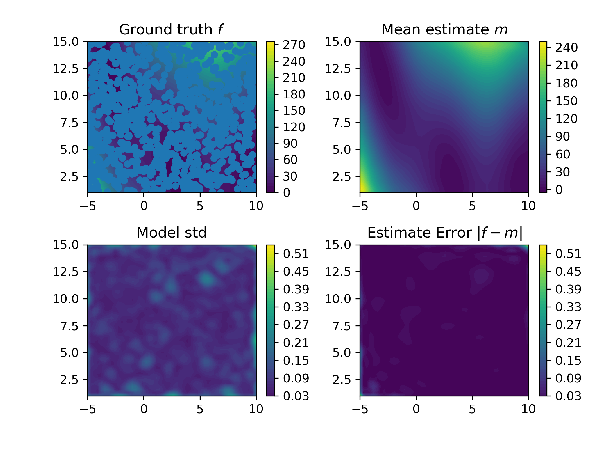

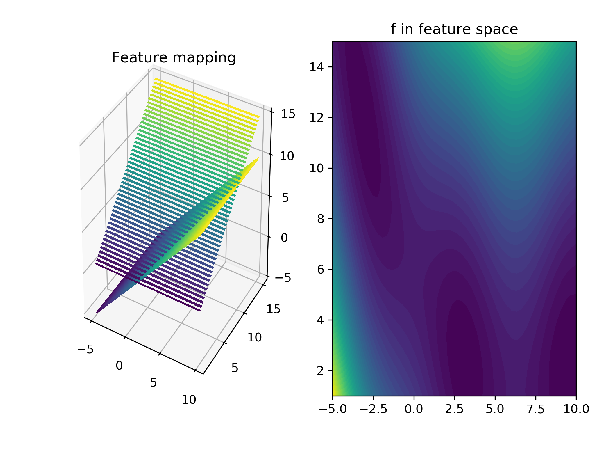

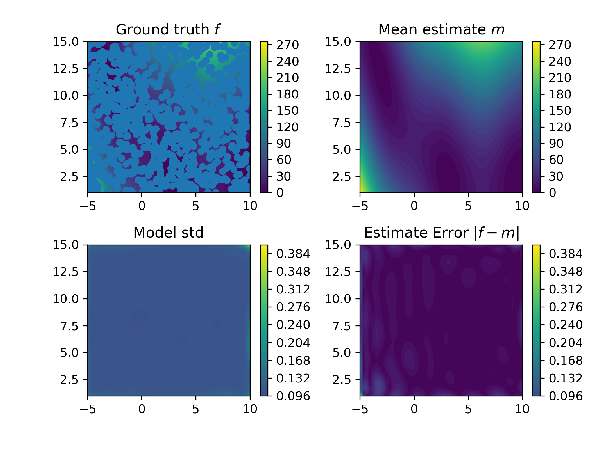

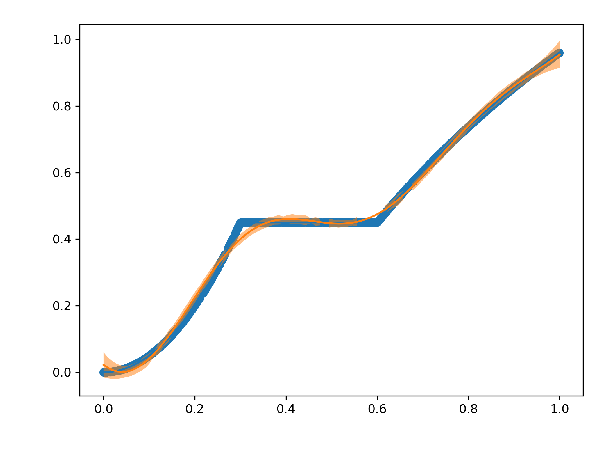

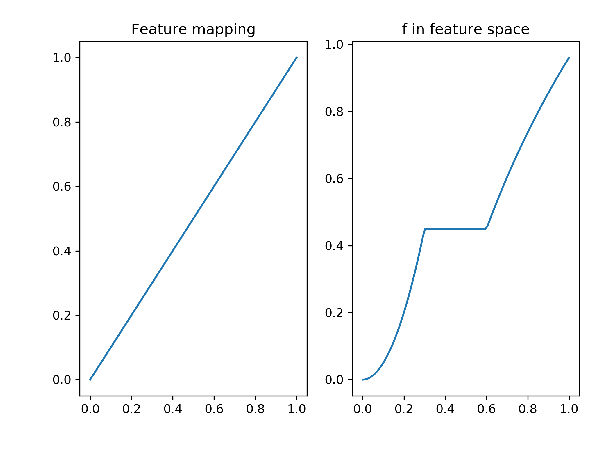

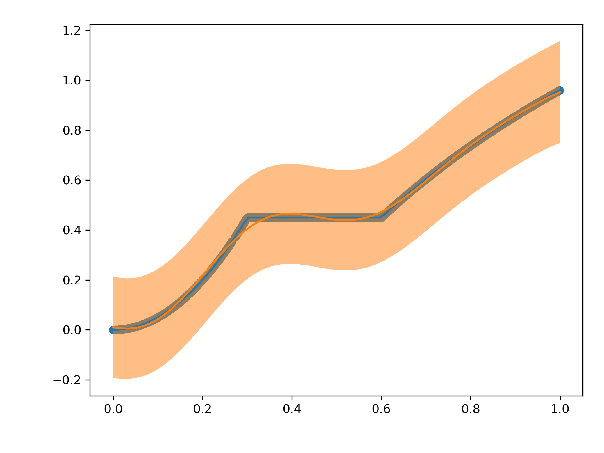

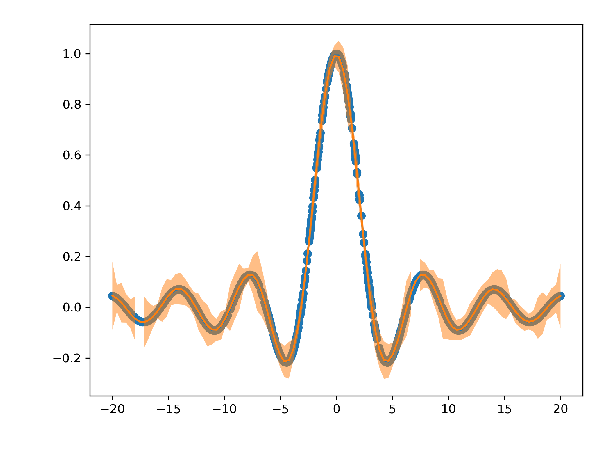

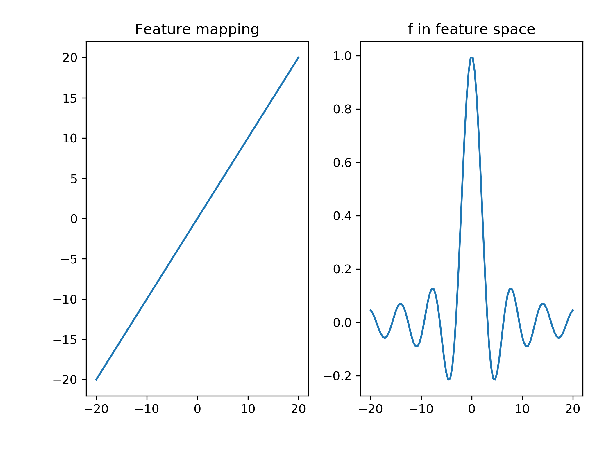

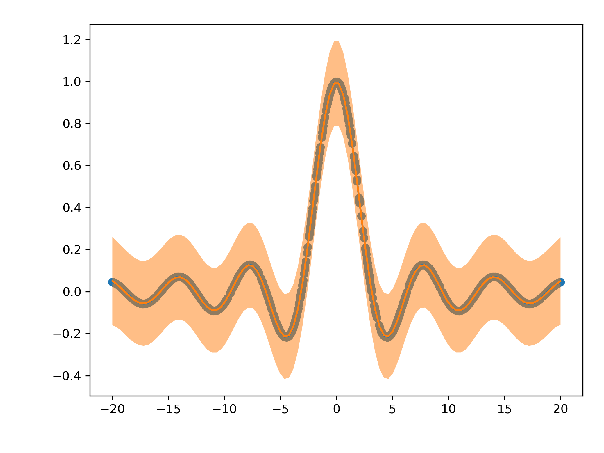

In [257]:
# (pick exp_hash and plot artifacts)
for func in functions:
    temp_df = exps_rows_df[exps_rows_df['f'] == func]               # for a given function
    max_idx = temp_df['result.model_compare:mean:max_err'].idxmax() # find the model with max err
    exp_row = temp_df.loc[max_idx]                                  # grab that model

    exp = exp_row.exp
    print(exp._id)
    for name, artifact in exp.artifacts.items():
        artifact.show()

In [258]:
# Box plot for fixed RESULT with MODEL marginalised (WATCH OUT that we dont agg too many models!)
model_df = model_df.reset_index().set_index('f')
model_df[[RESULT]].boxplot(by='f', rot=45)

NameError: name 'model_df' is not defined

### Hyperparam opt of DKL

In [259]:
exps_rows_df = df[df["tag"] == "DKL-properties"].copy()
exps_rows_df.set_index('model_hash').sort_index()

,acq,bo,config,exp,f,model,model2,name,result.max_err,result.model1:max_err,result.model1:rmse,result.model_compare:mean:max_err,result.model_compare:mean:rmse,result.model_compare:var:max_err,result.model_compare:var:rmse,result.rmse,tag
model_hash,,,,,,,,,,,,,,,,,
0a932a10f0b536285918bd94254713ac9ce05752,None,False,{'exp_hash': '81d9c5e611d9124dbe0a872719bb7d99...,"Experiment(id=150, name=lions)",TwoKinkDEmbedding,DKLGPModel,None,DKLGPModel TwoKinkDEmbedding,0.043982,NaN,NaN,NaN,NaN,NaN,NaN,0.009472,DKL-properties
0a932a10f0b536285918bd94254713ac9ce05752,None,False,{'exp_hash': '89c95c124823db0f135e24a5e1cdc3ed...,"Experiment(id=84, name=lions)",Kink2D,DKLGPModel,None,DKLGPModel Kink2D,2.220672,NaN,NaN,NaN,NaN,NaN,NaN,0.230515,DKL-properties
0a932a10f0b536285918bd94254713ac9ce05752,None,False,{'exp_hash': 'b06d0d06bb9001511f52a80f3a808c53...,"Experiment(id=64, name=lions)",Kink1D,DKLGPModel,None,DKLGPModel Kink1D,9631.613513,NaN,NaN,NaN,NaN,NaN,NaN,635.244723,DKL-properties
0a932a10f0b536285918bd94254713ac9ce05752,None,False,{'exp_hash': 'cc78820b89ab2c58b99b34e05729e993...,"Experiment(id=128, name=lions)",TwoKink2D,DKLGPModel,None,DKLGPModel TwoKink2D,0.091692,NaN,NaN,NaN,NaN,NaN,NaN,0.018355,DKL-properties
0a932a10f0b536285918bd94254713ac9ce05752,None,False,{'exp_hash': 'cc66315b4b9a062e9db4ace0db793d5b...,"Experiment(id=106, name=lions)",TwoKink1D,DKLGPModel,None,DKLGPModel TwoKink1D,0.043620,NaN,NaN,NaN,NaN,NaN,NaN,0.010110,DKL-properties
0abdcf13c60d633160931867b5c8a04774f1e00f,None,False,{'exp_hash': 'a9f6c4862cf3663e6bce1de28531b575...,"Experiment(id=46, name=lions)",Kink1D,DKLGPModel,None,DKLGPModel Kink1D,152.914815,NaN,NaN,NaN,NaN,NaN,NaN,8.043969,DKL-properties
0abdcf13c60d633160931867b5c8a04774f1e00f,None,False,{'exp_hash': '915933db4ddb4e9d1f861828304361ed...,"Experiment(id=114, name=lions)",TwoKink2D,DKLGPModel,None,DKLGPModel TwoKink2D,0.089232,NaN,NaN,NaN,NaN,NaN,NaN,0.015372,DKL-properties
0abdcf13c60d633160931867b5c8a04774f1e00f,None,False,{'exp_hash': 'f8c0f9d20caab7407462076b47505db7...,"Experiment(id=135, name=lions)",TwoKinkDEmbedding,DKLGPModel,None,DKLGPModel TwoKinkDEmbedding,0.046023,NaN,NaN,NaN,NaN,NaN,NaN,0.009454,DKL-properties
0abdcf13c60d633160931867b5c8a04774f1e00f,None,False,{'exp_hash': 'd14b3f624f26d4a40cd6dc2996018559...,"Experiment(id=92, name=lions)",TwoKink1D,DKLGPModel,None,DKLGPModel TwoKink1D,0.030290,NaN,NaN,NaN,NaN,NaN,NaN,0.006613,DKL-properties


In [260]:
# We sort averaged RMSE across functions for each model config.
model_rmse_df = exps_rows_df[exps_rows_df['model'] == 'DKLGPModel']

model_rmse_df['layers'] = model_rmse_df.apply(lambda row: row.config.model.kwargs.nn_kwargs.get('layers'), axis=1)
model_rmse_df['layers'] = model_rmse_df.apply(lambda row: tuple(row.layers) if row.layers is not None else (), axis=1)
model_rmse_df['n_iter'] = model_rmse_df.apply(lambda row: row.config.model.kwargs.get('n_iter'), axis=1)
model_rmse_df['learning_rate'] = model_rmse_df.apply(lambda row: row.config.model.kwargs.get('learning_rate'), axis=1)

# Average
model_rmse_df = model_rmse_df.groupby('model_hash').agg({
    'layers': 'first',
    'n_iter': 'first',
    'learning_rate': 'first',
    'result.rmse': np.nanmean, 
    'f': 'count'
})
model_rmse_df = model_rmse_df.sort_values('result.rmse')
model_rmse_df

,layers,n_iter,learning_rate,result.rmse,f
model_hash,,,,,
c8fda2c1c158956119b0186ae116789c8e7e4ba6,"(100, 50, 2)",100,0.01,1.803034,5
b7d7bb41c0520c6648b45cb5351e420528c64cf4,"(50, 2)",1000,0.05,1.826364,5
0abdcf13c60d633160931867b5c8a04774f1e00f,"(100, 50, 1)",100,0.01,1.838556,5
9cc8030b395bad4d72a656f9de29b4ed622f714b,"(50, 2)",1000,0.01,3.159017,5
4fc93576c52242b5b57558ecb50f3a008d7d38e6,"(100, 50, 1)",1000,0.10,3.358059,5
69d93e37bc7eaad4a591c3b983f798dbeca313ff,(),1000,NaN,4.509213,5
da9fb227bfaeb52cfdd499e32ce6376cb7cfa21c,"(50, 2)",100,0.05,7.830038,5
e5fc834dc45c3a0d3a9caa67974e5f4ffca43f91,(),100,NaN,8.189735,5
0cf0cbd7a7c05d6541936958b5ba09c049c9c642,"(50, 2)",100,0.01,9.423027,5


In [261]:
# Pick the DKL model with minimum RMSE across all functions.
model_hash = model_rmse_df['result.rmse'].idxmin()
model = exps_rows_df[exps_rows_df['model_hash'] == model_hash].iloc[0]
model

acq                                                                               None
bo                                                                               False
config                               {'exp_hash': 'f3a01169859bd9087845e5d62c331393...
exp                                                      Experiment(id=47, name=lions)
f                                                                               Kink1D
model                                                                       DKLGPModel
model2                                                                            None
model_hash                                    c8fda2c1c158956119b0186ae116789c8e7e4ba6
name                                                                 DKLGPModel Kink1D
result.max_err                                                                 200.293
result.model1:max_err                                                              NaN
result.model1:rmse                         

In [262]:
pprint_color(model.config)

{'exp_hash': 'f3a01169859bd9087845e5d62c331393a57f4a5a',
 'gp_samples': 1000,
 'gp_use_derivatives': False,
 'model': {'kwargs': {'learning_rate': 0.01,
                      'n_iter': 100,
                      'nn_kwargs': {'layers': [100, 50, 2]},
                      'noise': 0.01},
           'name': 'DKLGPModel'},
 'model_compare': False,
 'model_hash': 'c8fda2c1c158956119b0186ae116789c8e7e4ba6',
 'obj_func': {'name': 'Kink1D'},
 'seed': 284414934,
 'tag': 'DKL-properties',
 'verbosity': {'bo_show_iter': 30, 'plot': False}}



In [263]:
# Make a nice latex version
# \label{table:dkl-hyperparams}
model_rmse_tex_df = model_rmse_df.reset_index().set_index(['layers', 'n_iter', 'learning_rate'])[['result.rmse']].sort_index()
model_rmse_tex_df = model_rmse_tex_df.set_index(model_rmse_tex_df.index.rename(['Layers', 'Epochs', 'Learning rate']))
model_rmse_tex_df = model_rmse_tex_df.rename(columns={'result.rmse': '$L_2$'})
save_table(model_rmse_tex_df.to_latex(escape=False), 'dkl-hyperparams')
model_rmse_tex_df

\begin{tabular}{lllr}
\toprule
             &      &      &        $L_2$ \\
Layers & Epochs & Learning rate &              \\
\midrule
() & 100  & NaN &     8.189735 \\
             & 1000 & NaN &     4.509213 \\
(50, 2) & 100  & 0.01 &     9.423027 \\
             &      & 0.05 &     7.830038 \\
             &      & 0.10 &   133.263154 \\
             & 1000 & 0.01 &     3.159017 \\
             &      & 0.05 &     1.826364 \\
             &      & 0.10 &   127.102635 \\
(100, 50, 1) & 100  & 0.01 &     1.838556 \\
             &      & 0.05 &   762.801642 \\
             &      & 0.10 &    46.942766 \\
             & 1000 & 0.01 &  7043.646085 \\
             &      & 0.05 &  1891.771787 \\
             &      & 0.10 &     3.358059 \\
(100, 50, 2) & 100  & 0.01 &     1.803034 \\
             &      & 0.05 &    16.075903 \\
             &      & 0.10 &   140.842526 \\
             & 1000 & 0.01 &    10.568410 \\
             &      & 0.05 &   119.360991 \\
             &      & 0.10 

$L_2$
Layers       Epochs Learning rate             
()           100    NaN               8.189735
             1000   NaN               4.509213
(50, 2)      100    0.01              9.423027
                    0.05              7.830038
                    0.10            133.263154
             1000   0.01              3.159017
                    0.05              1.826364
                    0.10            127.102635
(100, 50, 1) 100    0.01              1.838556
                    0.05            762.801642
                    0.10             46.942766
             1000   0.01           7043.646085
                    0.05           1891.771787
                    0.10              3.358059
(100, 50, 2) 100    0.01              1.803034
                    0.05             16.075903
                    0.10            140.842526
             1000   0.01             10.568410
                    0.05            119.360991
                    0.10            103.245766

### Properties

In [151]:
exps_rows_df = df[df["tag"] == "DKL-properties"].copy()
exps_rows_df

,,acq,bo,config,exp,f,model,model2,model_hash,name,result.max_err,result.model1:max_err,result.model1:rmse,result.model_compare:mean:max_err,result.model_compare:mean:rmse,result.model_compare:var:max_err,result.model_compare:var:rmse,result.rmse,tag
exp_hash,id,,,,,,,,,,,,,,,,,,
8a04affcddce1d2d3f430bb6896967c6e7f4c12d,40,None,False,{'exp_hash': '8a04affcddce1d2d3f430bb6896967c6...,"Experiment(id=40, name=lions)",Kink1D,GPModel,None,1bce33ccbe2f7cb92cf123fef7bb371ddd687585,GPModel Kink1D,281.782088,NaN,NaN,NaN,NaN,NaN,NaN,8.565553,DKL-properties
b4f6b2cb86384f0aab154c7af00f0fb4550cf830,41,None,False,{'exp_hash': 'b4f6b2cb86384f0aab154c7af00f0fb4...,"Experiment(id=41, name=lions)",Kink1D,GPModel,None,71858731a7083910a34cb6754e3c37231c7bfaed,GPModel Kink1D,225.186257,NaN,NaN,NaN,NaN,NaN,NaN,7.548232,DKL-properties
3f4c8c2da5d74d8c4c8a9f050f1b438dc32f1f9e,43,None,False,{'exp_hash': '3f4c8c2da5d74d8c4c8a9f050f1b438d...,"Experiment(id=43, name=lions)",Kink1D,DKLGPModel,None,69d93e37bc7eaad4a591c3b983f798dbeca313ff,DKLGPModel Kink1D,412.768423,NaN,NaN,NaN,NaN,NaN,NaN,22.261545,DKL-properties
59dbf4106de6347884ed1009a4844986a7a939c1,44,None,False,{'exp_hash': '59dbf4106de6347884ed1009a4844986...,"Experiment(id=44, name=lions)",Kink1D,DKLGPModel,None,c60b9225f9034e2b17458ebfe4f2cd455806f8d6,DKLGPModel Kink1D,2949.343405,NaN,NaN,NaN,NaN,NaN,NaN,134.372790,DKL-properties
554c96b319589470017b1ccd3189aee764973777,45,None,False,{'exp_hash': '554c96b319589470017b1ccd3189aee7...,"Experiment(id=45, name=lions)",Kink1D,DKLGPModel,None,4a33a3a4f04eb0e1a5421711c4fee038edd048f8,DKLGPModel Kink1D,2693.510427,NaN,NaN,NaN,NaN,NaN,NaN,78.439449,DKL-properties
a9f6c4862cf3663e6bce1de28531b575469d3c21,46,None,False,{'exp_hash': 'a9f6c4862cf3663e6bce1de28531b575...,"Experiment(id=46, name=lions)",Kink1D,DKLGPModel,None,0abdcf13c60d633160931867b5c8a04774f1e00f,DKLGPModel Kink1D,152.914815,NaN,NaN,NaN,NaN,NaN,NaN,8.043969,DKL-properties
f3a01169859bd9087845e5d62c331393a57f4a5a,47,None,False,{'exp_hash': 'f3a01169859bd9087845e5d62c331393...,"Experiment(id=47, name=lions)",Kink1D,DKLGPModel,None,c8fda2c1c158956119b0186ae116789c8e7e4ba6,DKLGPModel Kink1D,200.293069,NaN,NaN,NaN,NaN,NaN,NaN,8.797606,DKL-properties
dab5081644e54fe27066835e463e21fda368df48,48,None,False,{'exp_hash': 'dab5081644e54fe27066835e463e21fd...,"Experiment(id=48, name=lions)",Kink1D,DKLGPModel,None,da9fb227bfaeb52cfdd499e32ce6376cb7cfa21c,DKLGPModel Kink1D,782.411553,NaN,NaN,NaN,NaN,NaN,NaN,38.854175,DKL-properties
b6a44af22287ccde1725ec6e1145586740e4bb30,49,None,False,{'exp_hash': 'b6a44af22287ccde1725ec6e11455867...,"Experiment(id=49, name=lions)",Kink1D,DKLGPModel,None,e5fc834dc45c3a0d3a9caa67974e5f4ffca43f91,DKLGPModel Kink1D,1136.687638,NaN,NaN,NaN,NaN,NaN,NaN,40.564451,DKL-properties


In [152]:
exps_rows_df.set_index(['model', 'kernel', 'layers', 'n_iter', 'learning_rate'])

KeyError: 'kernel'

{'exp_hash': '4962f94147e32bc49605621d0c9232bc519dd75a',
 'gp_samples': 1000,
 'gp_use_derivatives': False,
 'model': {'kwargs': {'learning_rate': 0.01,
                      'n_iter': 1000,
                      'nn_kwargs': {'layers': [100, 50, 2]},
                      'noise': 0.01},
           'name': 'DKLGPModel'},
 'model_hash': '2d39a5264910441a7b503542126a858e8bfbdcde',
 'obj_func': {'name': 'Kink2D'},
 'seed': 98596602,
 'tag': 'default',
 'verbosity': {'bo_show_iter': 30, 'plot': False}}



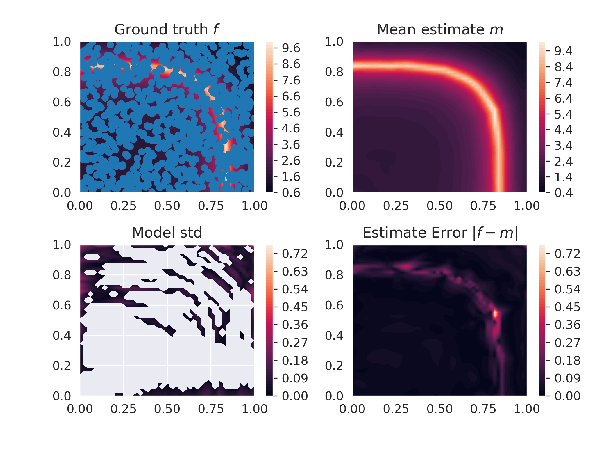

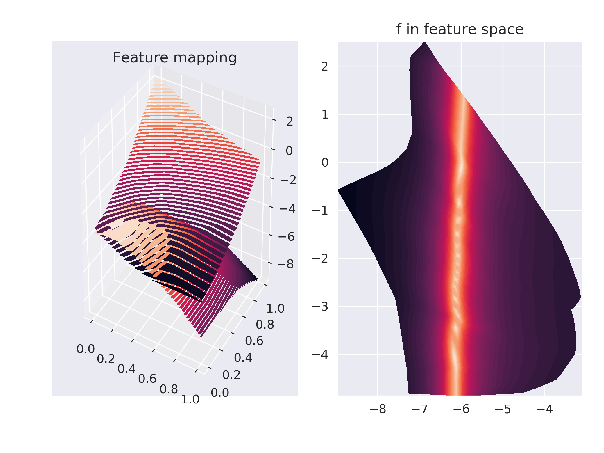

In [649]:
# select EXP_HASH
# We learn embedding. But what about lengthscale? Try on 1D where lengthscale is varying.

exp_row = exps_rows_df.loc['4962f94147e32bc49605621d0c9232bc519dd75a']
exp = exp_row.iloc[0].exp
pprint_color(exp.config)
for name, artifact in exp.artifacts.items():
    artifact.show()

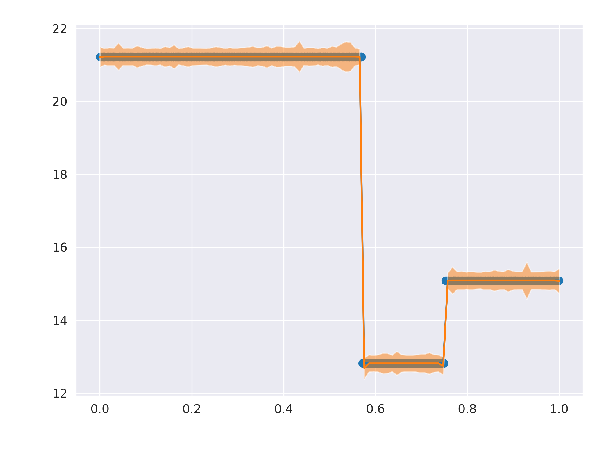

In [115]:
exp = exps_rows_df.loc['1140aeabb548f878cd07592d2061cbcde1e4012a']
exp = exp.exps[0]
for name, artifact in exp.artifacts.items():
    artifact.show()

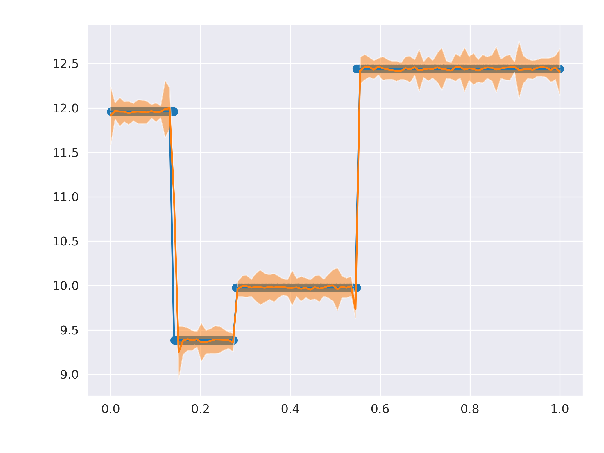

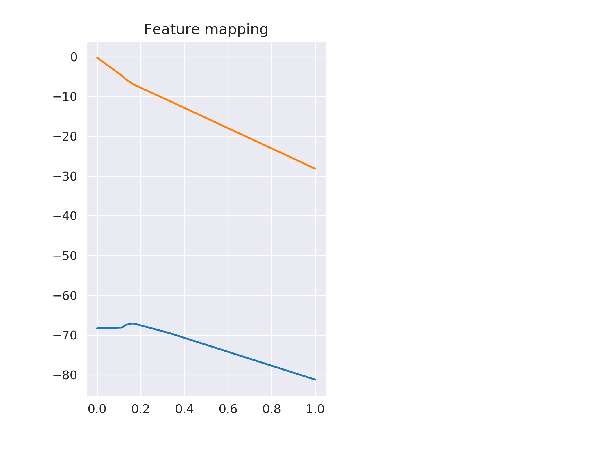

In [113]:
exp = exps_rows_df.loc['5173104e348f102cf1478d6066119d4d23293a79']
exp = exp.exps[0]
for name, artifact in exp.artifacts.items():
    artifact.show()

### Non-stationarity in low dim

In [236]:
exps_rows_df = df[df["tag"] == "DKL-properties"].copy()
exps_rows_df

,,acq,bo,config,exp,f,model,model2,model_hash,name,result.max_err,result.model1:max_err,result.model1:rmse,result.model_compare:mean:max_err,result.model_compare:mean:rmse,result.model_compare:var:max_err,result.model_compare:var:rmse,result.rmse,tag
exp_hash,id,,,,,,,,,,,,,,,,,,
8a04affcddce1d2d3f430bb6896967c6e7f4c12d,40,None,False,{'exp_hash': '8a04affcddce1d2d3f430bb6896967c6...,"Experiment(id=40, name=lions)",Kink1D,GPModel,None,1bce33ccbe2f7cb92cf123fef7bb371ddd687585,GPModel Kink1D,281.782088,NaN,NaN,NaN,NaN,NaN,NaN,8.565553,DKL-properties
b4f6b2cb86384f0aab154c7af00f0fb4550cf830,41,None,False,{'exp_hash': 'b4f6b2cb86384f0aab154c7af00f0fb4...,"Experiment(id=41, name=lions)",Kink1D,GPModel,None,71858731a7083910a34cb6754e3c37231c7bfaed,GPModel Kink1D,225.186257,NaN,NaN,NaN,NaN,NaN,NaN,7.548232,DKL-properties
3f4c8c2da5d74d8c4c8a9f050f1b438dc32f1f9e,43,None,False,{'exp_hash': '3f4c8c2da5d74d8c4c8a9f050f1b438d...,"Experiment(id=43, name=lions)",Kink1D,DKLGPModel,None,69d93e37bc7eaad4a591c3b983f798dbeca313ff,DKLGPModel Kink1D,412.768423,NaN,NaN,NaN,NaN,NaN,NaN,22.261545,DKL-properties
59dbf4106de6347884ed1009a4844986a7a939c1,44,None,False,{'exp_hash': '59dbf4106de6347884ed1009a4844986...,"Experiment(id=44, name=lions)",Kink1D,DKLGPModel,None,c60b9225f9034e2b17458ebfe4f2cd455806f8d6,DKLGPModel Kink1D,2949.343405,NaN,NaN,NaN,NaN,NaN,NaN,134.372790,DKL-properties
554c96b319589470017b1ccd3189aee764973777,45,None,False,{'exp_hash': '554c96b319589470017b1ccd3189aee7...,"Experiment(id=45, name=lions)",Kink1D,DKLGPModel,None,4a33a3a4f04eb0e1a5421711c4fee038edd048f8,DKLGPModel Kink1D,2693.510427,NaN,NaN,NaN,NaN,NaN,NaN,78.439449,DKL-properties
a9f6c4862cf3663e6bce1de28531b575469d3c21,46,None,False,{'exp_hash': 'a9f6c4862cf3663e6bce1de28531b575...,"Experiment(id=46, name=lions)",Kink1D,DKLGPModel,None,0abdcf13c60d633160931867b5c8a04774f1e00f,DKLGPModel Kink1D,152.914815,NaN,NaN,NaN,NaN,NaN,NaN,8.043969,DKL-properties
f3a01169859bd9087845e5d62c331393a57f4a5a,47,None,False,{'exp_hash': 'f3a01169859bd9087845e5d62c331393...,"Experiment(id=47, name=lions)",Kink1D,DKLGPModel,None,c8fda2c1c158956119b0186ae116789c8e7e4ba6,DKLGPModel Kink1D,200.293069,NaN,NaN,NaN,NaN,NaN,NaN,8.797606,DKL-properties
dab5081644e54fe27066835e463e21fda368df48,48,None,False,{'exp_hash': 'dab5081644e54fe27066835e463e21fd...,"Experiment(id=48, name=lions)",Kink1D,DKLGPModel,None,da9fb227bfaeb52cfdd499e32ce6376cb7cfa21c,DKLGPModel Kink1D,782.411553,NaN,NaN,NaN,NaN,NaN,NaN,38.854175,DKL-properties
b6a44af22287ccde1725ec6e1145586740e4bb30,49,None,False,{'exp_hash': 'b6a44af22287ccde1725ec6e11455867...,"Experiment(id=49, name=lions)",Kink1D,DKLGPModel,None,e5fc834dc45c3a0d3a9caa67974e5f4ffca43f91,DKLGPModel Kink1D,1136.687638,NaN,NaN,NaN,NaN,NaN,NaN,40.564451,DKL-properties


In [237]:
# DKLModel
dkl_df = exps_rows_df[exps_rows_df['model'] == 'DKLGPModel']

dkl_df['layers'] = dkl_df.apply(lambda row: row.config.model.kwargs.nn_kwargs.get('layers'), axis=1)
dkl_df['layers'] = dkl_df.apply(lambda row: tuple(row.layers) if row.layers is not None else (), axis=1)
dkl_df['n_iter'] = dkl_df.apply(lambda row: row.config.model.kwargs.get('n_iter'), axis=1)
dkl_df['learning_rate'] = dkl_df.apply(lambda row: row.config.model.kwargs.get('learning_rate'), axis=1)

dkl_df = dkl_df.groupby('exp_hash').agg({
    'layers': 'first',
    'n_iter': 'first',
    'learning_rate': 'first',
    'f': 'first',
    'result.rmse': np.nanmean,
})
dkl_df = dkl_df.set_index(['layers', 'n_iter', 'learning_rate', 'f']).sort_values('result.rmse').sort_index().unstack('f')
dkl_df

result.rmse                          \
f                                       Kink1D        Kink2D TwoKink1D   
layers       n_iter learning_rate                                        
()           100    NaN              40.564451      0.340182  0.010807   
             1000   NaN              22.261545      0.241523  0.010431   
(50, 2)      100    0.01             46.833457      0.245758  0.003105   
                    0.05             38.854175      0.259719  0.007192   
                    0.10            665.959308      0.319627  0.008811   
             1000   0.01             15.594846      0.175867  0.002129   
                    0.05              8.961886      0.149103  0.004047   
                    0.10            635.244723      0.230515  0.010110   
(100, 50, 1) 100    0.01              8.043969      1.117372  0.006613   
                    0.05            134.372790   3679.609431  0.006813   
                    0.10             32.934717    201.671027  0.008772   
             1000   0.01             19.029000  35199.185020  0.002050   
                    0.05           9123.170546    335.663872  0.005822   
                    0.10             14.214432      2.531896  0.009130   
(100, 50, 2) 100    0.01              8.797606      0.190712  0.003573   
                    0.05             78.439449      1.912683  0.004806   
                    0.10            703.212399      0.962892  0.009263   
             1000   0.01             52.721589      0.103437  0.002899   
                    0.05            596.646663      0.133583  0.006074   
                    0.10            514.400083      1.803077  0.006397   

                                                               
f                                 TwoKink2D TwoKinkDEmbedding  
layers       n_iter learning_rate                              
()           100    NaN            0.018990          0.014247  
             1000   NaN            0.018778          0.013787  
(50, 2)      100    0.01           0.020999          0.011813  
                    0.05           0.019159          0.009944  
                    0.10           0.016811          0.011213  
             1000   0.01           0.014711          0.007532  
                    0.05           0.011130          0.005657  
                    0.10           0.018355          0.009472  
(100, 50, 1) 100    0.01           0.015372          0.009454  
                    0.05           0.011307          0.007867  
                    0.10           0.062403          0.036911  
             1000   0.01           0.009799          0.004557  
                    0.05           0.013115          0.005580  
                    0.10           0.027594          0.007243  
(100, 50, 2) 100    0.01           0.013322          0.009958  
                    0.05           0.011888          0.010691  
                    0.10           0.018074          0.010003  
             1000   0.01           0.008708          0.005417  
                    0.05           0.011862          0.006774  
                    0.10           0.011852          0.007422

In [238]:
# GPModel
gp_df = exps_rows_df[exps_rows_df['model'] == 'GPModel']

gp_df['kernel'] = gp_df.apply(lambda row: row.config.model.kwargs.kernel.name, axis=1)

gp_df = gp_df.groupby('exp_hash').agg({
    'kernel': 'first',
    'f': 'first',
    'result.rmse': np.nanmean,
})
gp_df = gp_df.set_index(['kernel', 'f']).sort_values('result.rmse').sort_index().unstack('f')
gp_df

result.rmse                                                
f                Kink1D    Kink2D TwoKink1D TwoKink2D TwoKinkDEmbedding
kernel                                                                 
GPyMatern32    7.548232  0.226828  0.005441  0.016530          0.010103
GPyRBF         8.565553  0.313265  0.010500  0.020283          0.016816

In [239]:
# SG models
SG_df = create_SG_df(exps_rows_df, depth=10, refinement_level=12, f_tol=1e-4)
SG_df = SG_df[['result.rmse']].unstack('f')
SG_df

Fitting SG
Fitting A-SG
Fitting SG
Fitting A-SG
Fitting SG
Fitting A-SG
Fitting SG
Fitting A-SG
Fitting SG
Fitting A-SG


result.rmse                                                
f          Kink1D    Kink2D TwoKink1D TwoKink2D TwoKinkDEmbedding
model                                                            
A-SG     0.169221  0.297522  0.000010  0.003848          0.001406
SG       5.350762  0.093473  0.000009  0.001281          0.000703

In [240]:
dkl_mod_df = dkl_df.reset_index()
dkl_mod_df['name'] = dkl_mod_df[['layers', 'n_iter', 'learning_rate']].apply(tuple, axis=1)
dkl_mod_df = dkl_mod_df[['name', 'result.rmse']]
dkl_mod_df = dkl_mod_df[dkl_mod_df['name'] == ((100, 50, 2), 1000, 0.01)]

gp_mod_df = gp_df.reset_index()
gp_mod_df['name'] = gp_mod_df['kernel']
gp_mod_df = gp_mod_df[['name', 'result.rmse']]

SG_mod_df = SG_df.reset_index()
SG_mod_df['name'] = SG_mod_df['model']
SG_mod_df = SG_mod_df[['name', 'result.rmse']]

non_stat_df = pd.concat([dkl_mod_df, gp_mod_df, SG_mod_df])
non_stat_df

name result.rmse                                \
f                                   Kink1D    Kink2D TwoKink1D TwoKink2D   
17  ((100, 50, 2), 1000, 0.01)   52.721589  0.103437  0.002899  0.008708   
0                  GPyMatern32    7.548232  0.226828  0.005441  0.016530   
1                       GPyRBF    8.565553  0.313265  0.010500  0.020283   
0                         A-SG    0.169221  0.297522  0.000010  0.003848   
1                           SG    5.350762  0.093473  0.000009  0.001281   

                      
f  TwoKinkDEmbedding  
17          0.005417  
0           0.010103  
1           0.016816  
0           0.001406  
1           0.000703

In [247]:
# \label{table:non-stat}
save_table(non_stat_df.set_index('name').to_latex(escape=False), 'non-stat')

### Embeddings

In [242]:
exps_rows_df = df[df["tag"] == "embedding"].copy()
#exps_rows_df['description'] = exps_rows_df.apply(get_description)
temp_df = exps_rows_df.reset_index().set_index(['model', 'f']).sort_index()[['result.rmse', 'exp_hash', 'id']]
temp_df

result.rmse  \
model                        f                                 
DKLGPModel                   ActiveSubspaceTest     0.016763   
                             ActiveSubspaceTest     0.013939   
                             ActiveSubspaceTest     0.014630   
                             ActiveSubspaceTest     0.016375   
                             TwoKinkDEmbedding      0.003588   
                             TwoKinkDEmbedding      0.005470   
                             TwoKinkDEmbedding      0.005404   
                             TwoKinkDEmbedding      0.003531   
T<ActiveSubspace,DKLGPModel> ActiveSubspaceTest     0.002152   
                             ActiveSubspaceTest     0.001820   
                             ActiveSubspaceTest     0.001291   
                             TwoKinkDEmbedding      0.001118   
                             TwoKinkDEmbedding      0.001510   
T<ActiveSubspace,GPModel>    ActiveSubspaceTest     0.003557   
                             ActiveSubspaceTest     0.003364   
                             ActiveSubspaceTest     0.003640   
                             ActiveSubspaceTest     0.003817   
                             ActiveSubspaceTest     0.003540   
                             ActiveSubspaceTest     0.003798   
                             TwoKinkDEmbedding      0.003324   
                             TwoKinkDEmbedding      0.002443   
                             TwoKinkDEmbedding      0.003350   
                             TwoKinkDEmbedding      0.003804   
                             TwoKinkDEmbedding      0.003057   

                                                                                 exp_hash  \
model                        f                                                              
DKLGPModel                   ActiveSubspaceTest  8dc564bb22d7b00a62a8458c01fb3534f4c81035   
                             ActiveSubspaceTest  8dc564bb22d7b00a62a8458c01fb3534f4c81035   
                             ActiveSubspaceTest  8dc564bb22d7b00a62a8458c01fb3534f4c81035   
                             ActiveSubspaceTest  8dc564bb22d7b00a62a8458c01fb3534f4c81035   
                             TwoKinkDEmbedding   66c5c17a89ebc4d26d91d9fe26db0128bd1c97a3   
                             TwoKinkDEmbedding   66c5c17a89ebc4d26d91d9fe26db0128bd1c97a3   
                             TwoKinkDEmbedding   66c5c17a89ebc4d26d91d9fe26db0128bd1c97a3   
                             TwoKinkDEmbedding   66c5c17a89ebc4d26d91d9fe26db0128bd1c97a3   
T<ActiveSubspace,DKLGPModel> ActiveSubspaceTest  0f40fc8ee4a72f4a62acd4b0b9a92cf646c61e18   
                             ActiveSubspaceTest  0f40fc8ee4a72f4a62acd4b0b9a92cf646c61e18   
                             ActiveSubspaceTest  0f40fc8ee4a72f4a62acd4b0b9a92cf646c61e18   
                             TwoKinkDEmbedding   f6ad0cad4503f74565b7a06af6704718b3aed19d   
                             TwoKinkDEmbedding   f6ad0cad4503f74565b7a06af6704718b3aed19d   
T<ActiveSubspace,GPModel>    ActiveSubspaceTest  6268e62d48917a20a51f5ae136249afb31403f72   
                             ActiveSubspaceTest  6268e62d48917a20a51f5ae136249afb31403f72   
                             ActiveSubspaceTest  6268e62d48917a20a51f5ae136249afb31403f72   
                             ActiveSubspaceTest  6268e62d48917a20a51f5ae136249afb31403f72   
                             ActiveSubspaceTest  6268e62d48917a20a51f5ae136249afb31403f72   
                             ActiveSubspaceTest  6268e62d48917a20a51f5ae136249afb31403f72   
                             TwoKinkDEmbedding   98fbe0c7937a63655132ed49296eb2741d5cd531   
                             TwoKinkDEmbedding   98fbe0c7937a63655132ed49296eb2741d5cd531   
                             TwoKinkDEmbedding   98fbe0c7937a63655132ed49296eb2741d5cd531   
                             TwoKinkDEmbedding   98fbe0c7937a63655132ed49296eb2741d5cd531   
                             TwoKinkDEmbedding   98fbe0c793

In [243]:
temp_df = temp_df.groupby(['model', 'f']).agg({'result.rmse': 'mean'})
temp_df

result.rmse
model                        f                              
DKLGPModel                   ActiveSubspaceTest     0.015427
                             TwoKinkDEmbedding      0.004498
T<ActiveSubspace,DKLGPModel> ActiveSubspaceTest     0.001754
                             TwoKinkDEmbedding      0.001314
T<ActiveSubspace,GPModel>    ActiveSubspaceTest     0.003619
                             TwoKinkDEmbedding      0.003196

In [244]:
SG_df = create_SG_df(exps_rows_df)
SG_df

Fitting SG
Fitting A-SG
Fitting SG
Fitting A-SG


N  depth  result.rmse
model f                                           
A-SG  ActiveSubspaceTest  1265      3     0.004444
      TwoKinkDEmbedding   1530      3     0.003474
SG    ActiveSubspaceTest  1581      4     0.003924
      TwoKinkDEmbedding   1581      4     0.003261

In [245]:
# Mash the SG and other model results together.
mash_df = pd.concat([SG_df[['result.rmse']], temp_df]).unstack('f')
mash_df

result.rmse                  
f                            ActiveSubspaceTest TwoKinkDEmbedding
model                                                            
A-SG                                   0.004444          0.003474
DKLGPModel                             0.015427          0.004498
SG                                     0.003924          0.003261
T<ActiveSubspace,DKLGPModel>           0.001754          0.001314
T<ActiveSubspace,GPModel>              0.003619          0.003196

In [246]:
# Latex table
save_table(mash_df.to_latex(), 'embeddings')

In [922]:
exp_row = exps_rows_df.reset_index().set_index('id').loc[174]
exp = exp_row.exp
pprint_color(exp.config)
for name, artifact in exp.artifacts.items():
    artifact.show()

{'exp_hash': '98fbe0c7937a63655132ed49296eb2741d5cd531',
 'gp_samples': 1000,
 'gp_use_derivatives': True,
 'model': {'kwargs': {'prob_model': {'kwargs': {'do_optimize': True,
                                                'kernel': {'kwargs': {'lengthscale': 1},
                                                           'name': 'GPyRBF'},
                                                'noise_prior': 0.01,
                                                'num_mcmc': 0},
                                     'name': 'GPModel'},
                      'transformer': {'kwargs': {'output_dim': 1},
                                      'name': 'ActiveSubspace'}},
           'name': 'TransformerModel'},
 'model_compare': False,
 'model_hash': 'c4612198048600b72e0df42ab9ee2503d443f7b1',
 'obj_func': {'kwargs': {'Alpha': [[0.78695576],
                                   [0.70777112],
                                   [0.34515641],
                                   [0.20288506],
              

# (Temporary) Dumbster for scripting...

In [852]:
import numpy as np

D = 2
N_new = 5
N = 10

A = np.ones((N,D,D))
B = np.ones((N, N_new))
C = np.tensordot(B, A, axes=(0,0))
C.shape

(5, 2, 2)

/Users/tmpethick/anaconda3/envs/lions/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [684]:
# Dirty hack to filter out last experiment of curvature
exps_rows_df.exps.iloc['60519fa6dbfe5a80969a4b30ddd14cafbf68612f'] = exps_rows_df.exps.iloc['60519fa6dbfe5a80969a4b30ddd14cafbf68612f'][:-1]

TypeError: Cannot index by location index with a non-integer key

In [543]:
Lambda = np.identity(D)
(Lambda @ C)

array([[[10., 10.],
        [10., 10.]],

       [[10., 10.],
        [10., 10.]],

       [[10., 10.],
        [10., 10.]],

       [[10., 10.],
        [10., 10.]],

       [[10., 10.],
        [10., 10.]]])

In [558]:
N = 2
D = 2
N_new = 3
A = np.arange(N * D).reshape(N, D)
B = np.arange(N_new * D).reshape(N_new, D)

(A[:, None, :] - B[None, :, :])

array([[[ 0,  0],
        [-2, -2],
        [-4, -4]],

       [[ 2,  2],
        [ 0,  0],
        [-2, -2]]])

In [523]:
X_new = np.arange(5 * 2).reshape((5, 2))
X = np.arange(10 * 2).reshape((10, 2))

np.einsum('ik,jk->ijk', X_new, -X).shape

(5, 10, 2)

In [538]:
X = np.arange(5)
La = np.ones(5 * 5).reshape((5, 5))
np.einsum("ij,i->i", La, X)

array([ 0.,  5., 10., 15., 20.])

In [527]:
# Summing a and b
k_Xx = np.ones((N_new, N, D))
Ones = np.ones((N_new, N, D, D))
alpha = np.ones((N, 1))

np.einsum("ijkl,ijk->ikl", Ones, k_Xx * alpha)
np.einsum("jik,jik->ik", k_Xx, k_Xx)

array([[5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.]])

# Single experiment explorer

In [872]:
# Find the latest (using internal api of loader...)
exp = loader._runs.find().sort([('timestamp', -1)]).limit(1)[0]
exp = loader._make_experiment(exp)

In [66]:
exp

Experiment(id=1, name=lions)

In [17]:
#exp = loader.find_by_id(-1)

def artifact_to_numpy(artifact):
    return np.load(artifact.file)

X = artifact_to_numpy(exp.artifacts['X.npy'])
Y = artifact_to_numpy(exp.artifacts['Y.npy'])

bo_plots_dict = get_bo_plots(exp)
bo_plots = [bo_plots_dict[k] for k in sorted(bo_plots_dict.keys())]

KeyError: 'X.npy'

In [875]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(i=(0, len(bo_plots)-1))
def show_bo_plot(i):
    bo_plots[i].show()

interactive(children=(IntSlider(value=0, description='i', max=1), Output()), _dom_classes=('widget-interact',)…

In [877]:
exp.metrics['rmse'].plot()

KeyError: 'rmse'

## Reconstruct model

In [ ]:
# TODO:
# runner (in reconstruction mode)
# refit model

# Dangour Zone! (migrations and delete)

In [526]:
# Accces MongoDB directly
from pymongo import MongoClient
client = MongoClient(settings.MONGO_DB_URL)
db = client[settings.MONGO_DB_NAME]
col = db['runs']

In [768]:
query = {"config.tag": "certify-ExactDKL"}

In [207]:
########################### Delete Zone! ###############################

In [770]:
query = {}
loader.find(query)

[Experiment(id=1, name=lions),
 Experiment(id=2, name=lions),
 Experiment(id=3, name=lions),
 Experiment(id=4, name=lions),
 Experiment(id=5, name=lions),
 Experiment(id=6, name=lions),
 Experiment(id=7, name=lions),
 Experiment(id=8, name=lions),
 Experiment(id=9, name=lions),
 Experiment(id=10, name=lions),
 Experiment(id=11, name=lions),
 Experiment(id=12, name=lions),
 Experiment(id=13, name=lions),
 Experiment(id=14, name=lions),
 Experiment(id=15, name=lions),
 Experiment(id=16, name=lions),
 Experiment(id=17, name=lions),
 Experiment(id=18, name=lions),
 Experiment(id=19, name=lions),
 Experiment(id=20, name=lions),
 Experiment(id=21, name=lions),
 Experiment(id=22, name=lions),
 Experiment(id=23, name=lions),
 Experiment(id=24, name=lions),
 Experiment(id=25, name=lions),
 Experiment(id=26, name=lions),
 Experiment(id=27, name=lions),
 Experiment(id=28, name=lions),
 Experiment(id=29, name=lions),
 Experiment(id=30, name=lions),
 Experiment(id=31, name=lions),
 Experiment(id=32

In [771]:
for exp in loader.find(query):
    exp.delete(confirmed=True)